In [1]:
%reload_ext autoreload
%autoreload 2

# Transport

## Waveform generation

In [2]:

import numpy as np
from pytrans import objectives as obj
from pytrans.conversion import freq_to_curv
from pytrans.ions import Ca40
from pytrans.functions import zpspace
from pytrans.solver import solver, init_waveform

from models.surface_trap import SurfaceTrap
from pathlib import Path



_dir = Path('.').resolve() / 'data'

trap = SurfaceTrap()

axial = freq_to_curv(1e6, ion=Ca40)
rtilt = 8e7

n_samples = 50
x_traj = zpspace(trap.x_ele(2), trap.x_ele(4), n_samples, k=5, gap=1.75)
y0 = 0
z0 = trap.z0

waveform = init_waveform(n_samples, trap.n_electrodes)

objectives = []

# fill objectives per-step
def step_objective(voltages, x):
    return [
        obj.GradientObjective(voltages, trap, x, y0, z0, value=0, ion=Ca40),
        obj.HessianObjective(voltages, trap, x, y0, z0, entries='xx', value=axial, ion=Ca40, pseudo=False),
        obj.HessianObjective(voltages, trap, x, y0, z0, entries='yz', value=rtilt, ion=Ca40, pseudo=False),
    ]

for j, x0 in enumerate(x_traj):
    objectives += step_objective(waveform[j], x0)

objectives += [
    obj.VoltageObjective(waveform, 0),
    obj.VoltageObjective(waveform, 10, constraint_type='<='),
    obj.VoltageObjective(waveform, -10, constraint_type='>='),
    obj.SlewRateObjective(waveform, dt=trap.dt, weight=1e4)
    # obj.SlewRateObjective(waveform, value=4e6, dt=trap.dt, constraint_type='<=')  # V/s
]

_ = solver(objectives, verbose=True)
waveform = waveform.value  # get array from cvxpy variable

savename = _dir / 'waveform_transport.npy'
print(f"Saving waveform as ndarray to {savename}")
np.save(savename, waveform)


Compiling objectives: 100%|██████████| 154/154 [00:00<00:00, 362.75it/s]

                                     CVXPY                                     
                                     v1.3.0                                    
(CVXPY) Jun 23 08:42:04 PM: Your problem has 600 variables, 2 constraints, and 0 parameters.
(CVXPY) Jun 23 08:42:04 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jun 23 08:42:04 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jun 23 08:42:04 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jun 23 08:42:04 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Jun 23 08:42:04 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing 

(CVXPY) Jun 23 08:42:04 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jun 23 08:42:04 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Jun 23 08:42:04 PM: Applying reduction MOSEK
(CVXPY) Jun 23 08:42:04 PM: Finished problem compilation (took 3.450e-01 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Jun 23 08:42:04 PM: Invoking solver MOSEK  to obtain a solution.


(CVXPY) Jun 23 08:42:04 PM: Problem
(CVXPY) Jun 23 08:42:04 PM:   Name                   :                 
(CVXPY) Jun 23 08:42:04 PM:   Objective sense        : max             
(CVXPY) Jun 23 08:42:04 PM:   Type                   : CONIC (conic optimization problem)
(CVXPY) Jun 23 08:42:04 PM:   Constraints            : 1340            
(CVXPY) Jun 23 08:42:04 PM:   Cones                  : 151             
(CVXPY)

## Analysis

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from models.surface_trap import SurfaceTrap
from models.surface_trap.plot import plot_voltages_on_trap
from pytrans.analysis import analyse_potential
from pytrans.plotting.plotting import plot_potential_make_layout

from pytrans.ions import Ca40, Be9

In [4]:
trap = SurfaceTrap()
waveform = np.load(_dir / 'waveform_transport.npy')

Analyse first / middle / last sample

--------------
Trap potential analysis for ion Ca40: 
Equilibrium position [um]
[100.0012   0.0001  67.0813]
Gradient [V/m]
[ 0.0088 -0.0017 -0.4119]
Displacement at 1 MHz [um]
[ 0.0005 -0.0001 -0.0252]
Hessian [V/m2]
[[ 1.6351e+07 -7.2772e+05 -5.5896e+05]
 [-7.2772e+05  6.2880e+08  8.0000e+07]
 [-5.5896e+05  8.0000e+07  5.6382e+08]]
Normal mode frequencies [MHz]
[0.999957 5.58463 6.46139]
Eigenvectors
[[1 0.00108 0.000864]
 [-0.000116 -0.558 0.83]
 [0.00137 -0.83 -0.558]]
Tilt angle of mode 2 (6.46): -146.05°

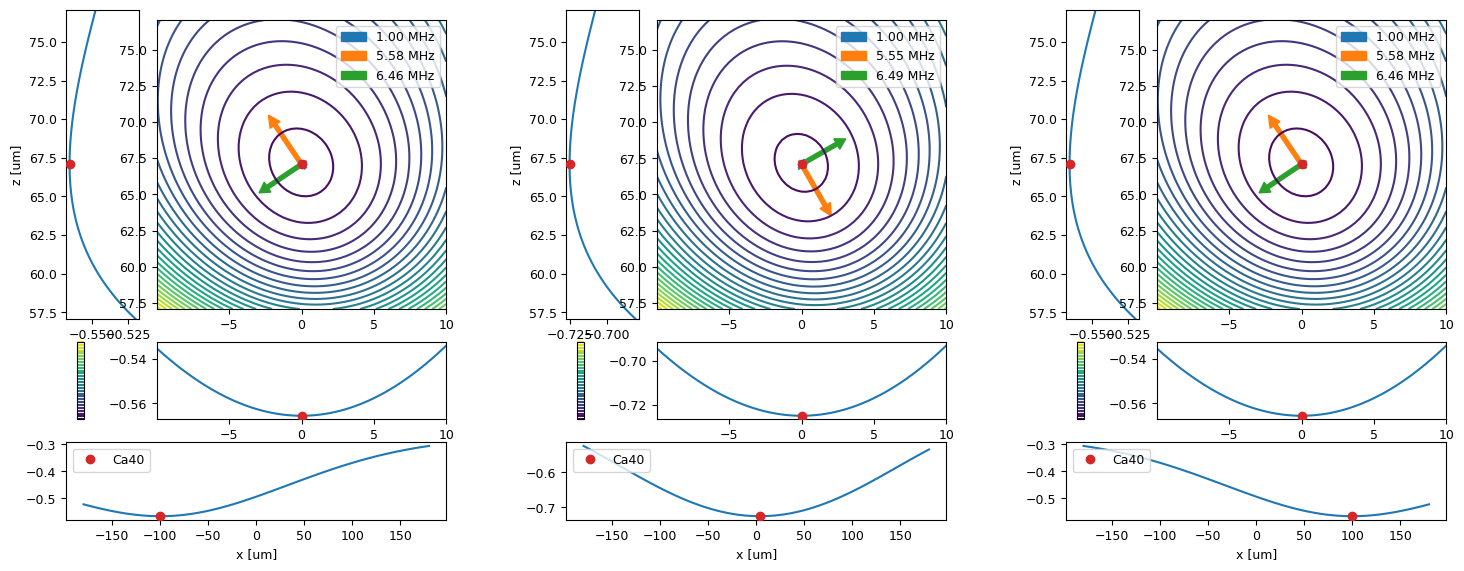

In [5]:
r0 = (0, 0, trap.z0)
roi = ((-180e-6, 180e-6), 10e-6, 10e-6)

_kwargs = dict(ions=Ca40, r0=r0, roi=roi, verbose=False)

fig, axes = plot_potential_make_layout(3)
res1 = analyse_potential(trap, voltages=waveform[0], axes=axes[0], **_kwargs)
res1 = analyse_potential(trap, voltages=waveform[len(waveform) // 2], axes=axes[1], **_kwargs)
res2 = analyse_potential(trap, voltages=waveform[-1], axes=axes[2], **_kwargs)

res2

In [6]:
from pytrans.analysis import analyse_waveform

In [7]:
r0s = [(x, 0, trap.z0) for x in x_traj]

# ions = [Be9, Ca40, Be9]
ions = [Ca40, Ca40]
results = analyse_waveform(trap, waveform, ions=ions, ion1=Ca40, r0=r0s, roi=roi)

x_eq = np.stack([r.x_eq * 1e6 for r in results], axis=0)
freqs = np.stack([r.mode_freqs * 1e-6 for r in results], axis=0)

x_eq2 = np.stack([r.mode_solver_results.x_eq * 1e6 for r in results], axis=0)
freqs2 = np.stack([r.mode_solver_results.mode_freqs * 1e-6 for r in results], axis=0)


Waveform analysis: 100%|██████████| 50/50 [00:04<00:00, 10.54it/s]


In [8]:
x_eq.shape, x_eq2.shape, freqs.shape, freqs2.shape


((50, 3), (50, 2, 3), (50, 3), (50, 6))

In [9]:
freqs2[0]

array([0.9994448 , 1.73150495, 5.49454659, 5.58476893, 6.383638  ,
       6.46146753])

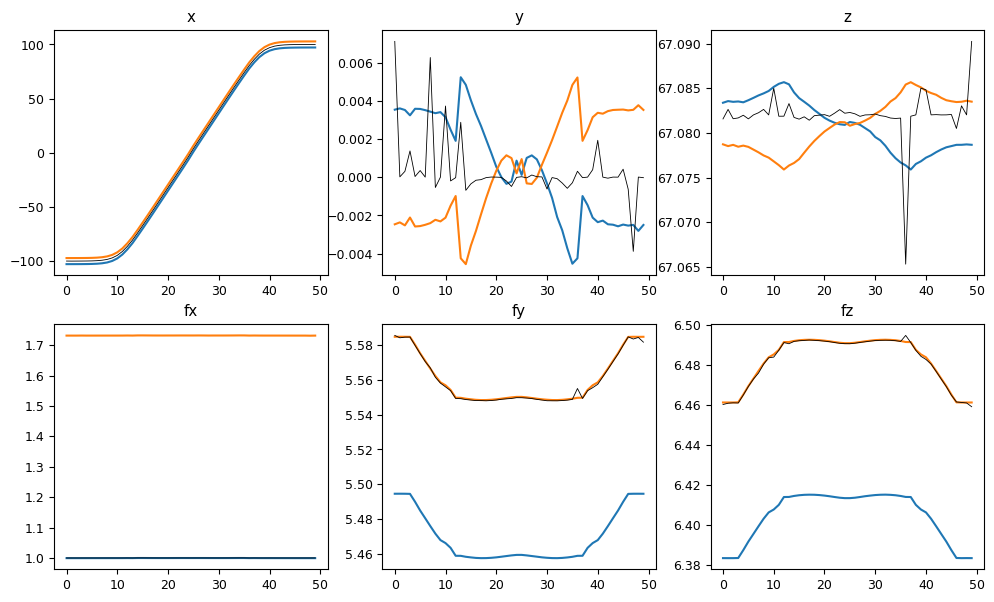

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(12, 7))

for j, c in enumerate('xyz'):
    ax = axes[0][j]
    ax.plot(x_eq2[:, :, j], '-', ms=1)
    ax.plot(x_eq[:, j], 'k', lw=0.6)
    ax.set_title(c)

    ax = axes[1][j]
    ax.plot(freqs2[:, 2*j], '-', ms=1)
    ax.plot(freqs2[:, 2*j + 1], '-', ms=1)
    ax.plot(freqs[:, j], 'k', lw=0.6)
    ax.set_title('f' + c)


In [11]:
xx = x_eq[:, 0]
freqs.shape

(50, 3)

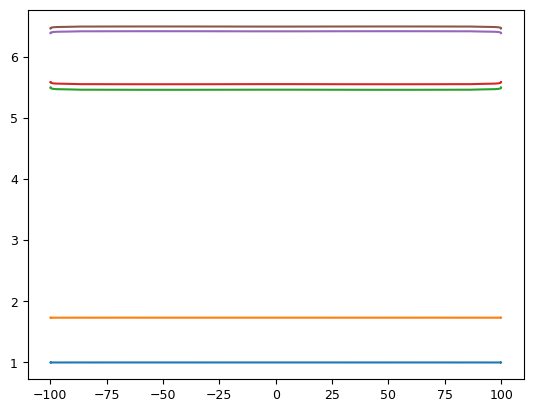

In [12]:

plt.plot(xx, freqs2);

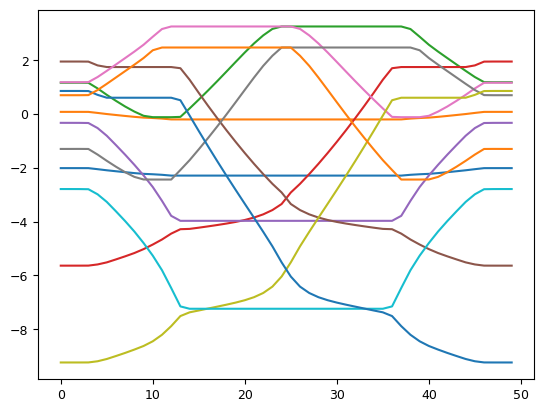

In [13]:
plt.plot(waveform); 

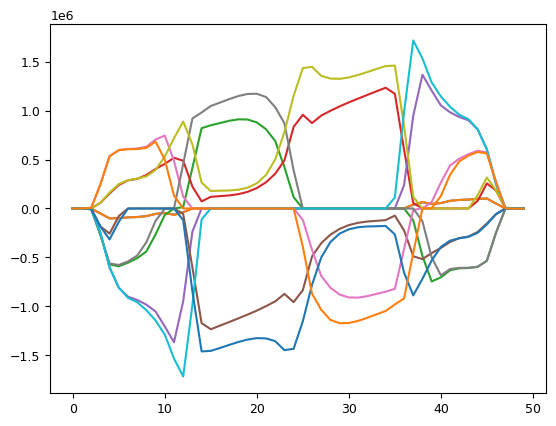

In [14]:
v_diff = np.gradient(waveform, axis=0) / trap.dt
plt.plot(v_diff);

In [15]:
# from models.surface_trap.plot import animate_waveform_on_trap

# ani = animate_waveform_on_trap(trap, waveform)
# ani.save('waveform.gif')


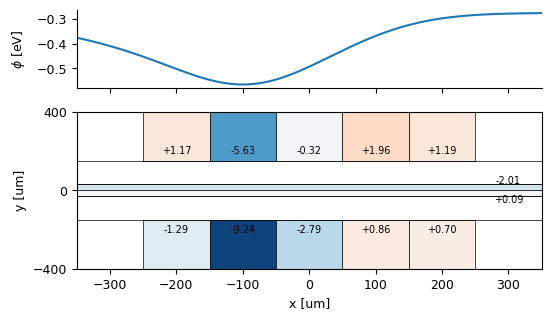

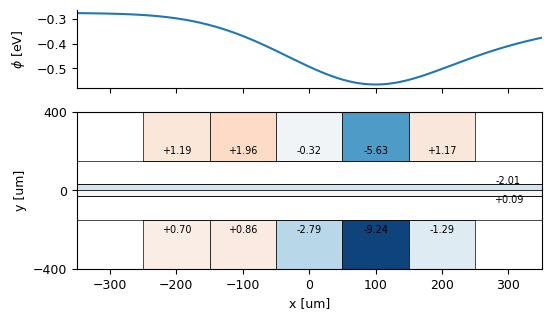

In [16]:
_ = plot_voltages_on_trap(trap, waveform[0])
_ = plot_voltages_on_trap(trap, waveform[-1])


In [17]:
r = results[0]

In [18]:
import json

rj = r.to_json()
with open('r0.json', 'w') as fp:
    json.dump(rj, fp)